In [1]:
# Import necessary libraries
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### EDA: 
##### Check the size of each set

In [2]:
# Define the directories
base_dir = '//Users/yijing/Desktop/Machine Learning/Class_Project/sports_image'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Function to count images in each set
def count_images_in_directory(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            total_images += len([img for img in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, img))])
    return total_images

# Print the number of images in the original sets
original_train_count = count_images_in_directory(train_dir)
original_valid_count = count_images_in_directory(valid_dir)
original_test_count = count_images_in_directory(test_dir)

print(f'Original training set size: {original_train_count}')
print(f'Original validation set size: {original_valid_count}')
print(f'Original test set size: {original_test_count}')

# The validation and test set is relatively small. I would like to resize them.

Original training set size: 13493
Original validation set size: 500
Original test set size: 500


#### Data Preparation: 
##### Resizing each set

In [3]:
# Function to get image paths and labels from a directory
def get_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for img_file in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_file)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(subdir)
    return image_paths, labels

# Get image paths and labels from all directories
train_image_paths, train_labels = get_image_paths_and_labels(train_dir)
valid_image_paths, valid_labels = get_image_paths_and_labels(valid_dir)
test_image_paths, test_labels = get_image_paths_and_labels(test_dir)

# Combine all image paths and labels
all_image_paths = train_image_paths + valid_image_paths + test_image_paths
all_labels = train_labels + valid_labels + test_labels

# New sizes
new_train_size = 10353
new_valid_size = new_test_size = 2070

# Split the data into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(all_image_paths, all_labels, train_size=new_train_size, stratify=all_labels)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=new_test_size, stratify=temp_labels)

# Display the sizes of the new datasets
print(f'New training set size: {len(train_paths)}')
print(f'New validation set size: {len(valid_paths)}')
print(f'New test set size: {len(test_paths)}')


New training set size: 10353
New validation set size: 2070
New test set size: 2070


In [4]:
def move_images(image_paths, labels, target_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(target_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path)))

# Define new target directories
new_train_dir = os.path.join(base_dir, 'new_train')
new_valid_dir = os.path.join(base_dir, 'new_valid')
new_test_dir = os.path.join(base_dir, 'new_test')

# Create target directories if they don't exist
for dir_path in [new_train_dir, new_valid_dir, new_test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Move the images to the new directories
move_images(train_paths, train_labels, new_train_dir)
move_images(valid_paths, valid_labels, new_valid_dir)
move_images(test_paths, test_labels, new_test_dir)


#### Feature Engineering & Transformations 
##### Create an ImageDataGenerator for data augmentation and preprocessing

In [5]:
# Define augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values to the range [0, 1]
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Apply 20% zoom transformations 
    horizontal_flip=True,  # Apply horizontal flips
    # vertical_flip=True,  # Apply vertical flips
    # validation_split=0.2#, # Set the validation split
    # featurewise_center=True,  # Perform feature-wise centering; must be fit to training data first
    # featurewise_std_normalization=True  # Perform feature-wise standardization; must be fit to training data first
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Create data generators that load images from directories and preprocess them
train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=(64, 64),  # Resize images to 64x64 pixels, even though 224x224 pixels is commonly used, I choose to use 64x64 to save time on training models
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
)

valid_generator = valid_datagen.flow_from_directory(
    new_valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    new_test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
)

Found 10091 images belonging to 100 classes.
Found 2059 images belonging to 100 classes.
Found 2056 images belonging to 100 classes.


In [6]:
# Print final confirmation of dataset sizes
print(f'Final training set size: {len(train_generator.filepaths)}')
print(f'Final validation set size: {len(valid_generator.filepaths)}')
print(f'Final test set size: {len(test_generator.filepaths)}')

print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

Final training set size: 10091
Final validation set size: 2059
Final test set size: 2056
{'air hockey': 0, 'ampute football': 1, 'archery': 2, 'arm wrestling': 3, 'axe throwing': 4, 'balance beam': 5, 'barell racing': 6, 'baseball': 7, 'basketball': 8, 'baton twirling': 9, 'bike polo': 10, 'billiards': 11, 'bmx': 12, 'bobsled': 13, 'bowling': 14, 'boxing': 15, 'bull riding': 16, 'bungee jumping': 17, 'canoe slamon': 18, 'cheerleading': 19, 'chuckwagon racing': 20, 'cricket': 21, 'croquet': 22, 'curling': 23, 'disc golf': 24, 'fencing': 25, 'field hockey': 26, 'figure skating men': 27, 'figure skating pairs': 28, 'figure skating women': 29, 'fly fishing': 30, 'football': 31, 'formula 1 racing': 32, 'frisbee': 33, 'gaga': 34, 'giant slalom': 35, 'golf': 36, 'hammer throw': 37, 'hang gliding': 38, 'harness racing': 39, 'high jump': 40, 'hockey': 41, 'horse jumping': 42, 'horse racing': 43, 'horseshoe pitching': 44, 'hurdles': 45, 'hydroplane racing': 46, 'ice climbing': 47, 'ice yachting'

#### EDA: 
##### Data Distribution: Analyze the number of images in each sports category to identify any class imbalances.

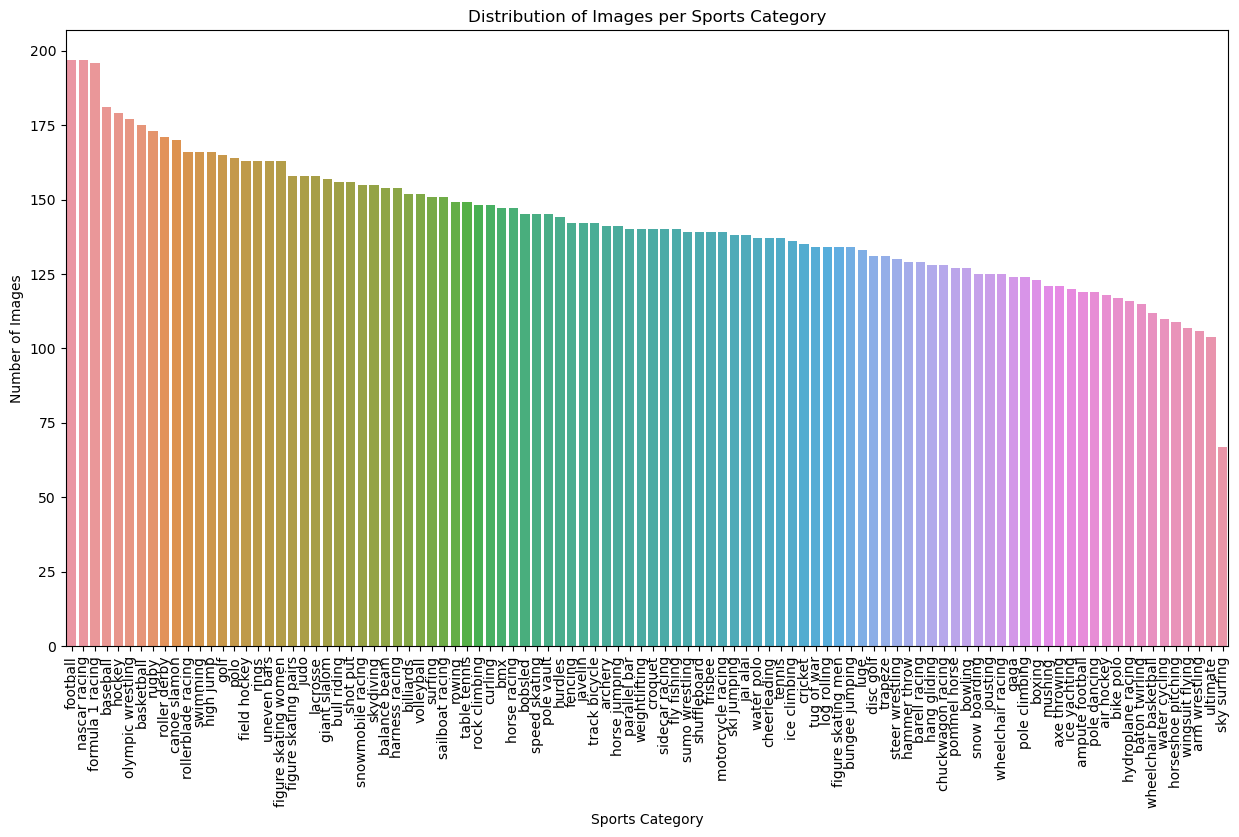

In [7]:
def count_images_in_categories(directory):
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    image_counts = Counter()
    
    for category in categories:
        category_path = os.path.join(directory, category)
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        image_counts[category] += len(image_files)
    
    return image_counts

# Count images in each set
train_counts = count_images_in_categories(new_train_dir)
valid_counts = count_images_in_categories(new_valid_dir)
test_counts = count_images_in_categories(new_test_dir)

# Combine counts from all sets
total_counts = train_counts + valid_counts + test_counts

# Convert to a pandas DataFrame for better visualization
counts_df = pd.DataFrame.from_dict(total_counts, orient='index', columns=['Image Count'])
counts_df = counts_df.sort_values(by='Image Count', ascending=False)

# Plot the distribution of images per category
plt.figure(figsize=(15, 8))
sns.barplot(x=counts_df.index, y=counts_df['Image Count'])
plt.xticks(rotation=90)
plt.xlabel('Sports Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Sports Category')
plt.show()

#### EDA: Image Preview: Randomly display a selection of images to visually inspect their quality and content.

In [8]:
def display_random_images(directory, num_images=5):
    """
    Randomly display a selection of images from the specified directory.

    :param directory: Path to the directory containing image subfolders.
    :param num_images: Number of random images to display.
    """
    # Get list of all subdirectories (categories)
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # Collect all image paths
    image_paths = []
    for category in categories:
        category_path = os.path.join(directory, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
        image_paths.extend(images)
    
    # Randomly select image paths to display
    selected_images = random.sample(image_paths, num_images)
    
    # Display images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()


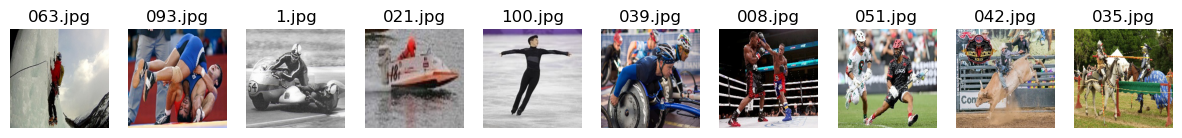

In [9]:
display_random_images(new_train_dir, num_images=10)

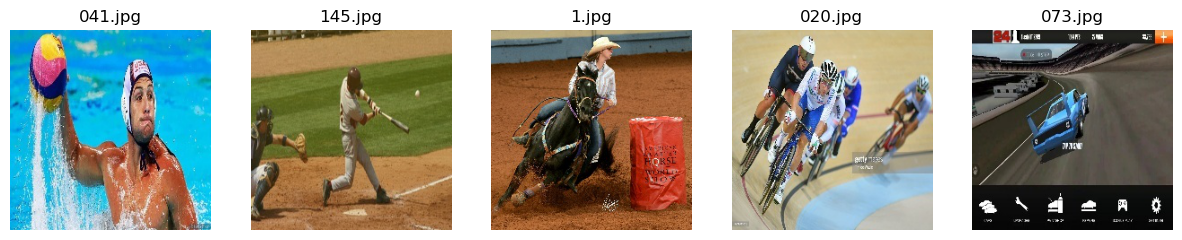

In [10]:
display_random_images(new_valid_dir, num_images=5)

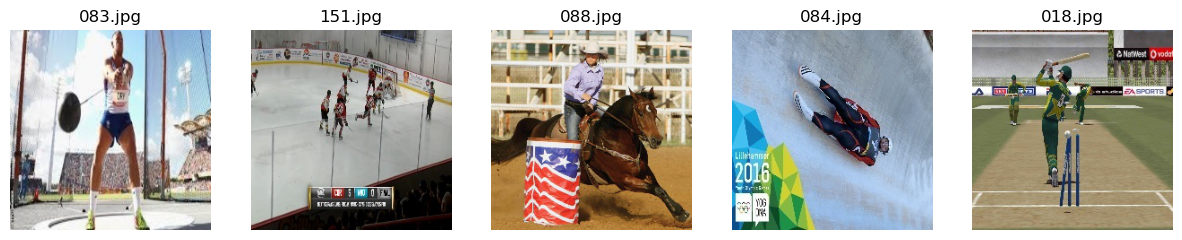

In [11]:
display_random_images(new_test_dir, num_images=5)

#### CNN Model

In [12]:
num_classes = len(train_generator.class_indices)
input_shape = (64, 64, 3)

In [13]:
# Try one-layer CNN model with a Dense layer size of 128 & 256

def cnn_model_1(input_shape, num_classes, dense_units):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Loop over different Dense layer sizes
dense_sizes = [128, 256]
results = {}

for dense_size in dense_sizes:
    print(f"Training model with Dense layer size: {dense_size}")
    model = cnn_model_1(input_shape, num_classes, dense_size)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=280,
        epochs=10,
        validation_data=valid_generator,
        verbose=0
    )
    
    train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
    valid_loss, valid_accuracy = model.evaluate(valid_generator, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    
    results[dense_size] = {
        "train_accuracy": train_accuracy,
        "valid_accuracy": valid_accuracy,
        "test_accuracy": test_accuracy
    }
    
    print(f"Final accuracy on train set: {train_accuracy:.4f}")
    print(f"Final accuracy on validation set: {valid_accuracy:.4f}")
    print(f"Final accuracy on test set: {test_accuracy:.4f}")

# Print results
for dense_size, result in results.items():
    print(f"Dense size: {dense_size}")
    print(f"Train accuracy: {result['train_accuracy']:.4f}")
    print(f"Validation accuracy: {result['valid_accuracy']:.4f}")
    print(f"Test accuracy: {result['test_accuracy']:.4f}")

Training model with Dense layer size: 128


/Users/yijing/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/yijing/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-22 18:45:39.233512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/yijing/opt/anaconda3/lib/python3.11/contextlib.py:158: Use

Final accuracy on train set: 0.1819
Final accuracy on validation set: 0.1520
Final accuracy on test set: 0.1483
Training model with Dense layer size: 256


2024-05-22 18:47:23.818976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 18:47:43.259010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 18:48:02.635348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 18:48:21.648752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 18:48:40.526641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final accuracy on train set: 0.3082
Final accuracy on validation set: 0.2632
Final accuracy on test set: 0.2471
Dense size: 128
Train accuracy: 0.1819
Validation accuracy: 0.1520
Test accuracy: 0.1483
Dense size: 256
Train accuracy: 0.3082
Validation accuracy: 0.2632
Test accuracy: 0.2471


#### The model with a Dense layer size of 256 showed a slight improvement in train and test accuracy compared to the model with a Dense layer size of 128.

#### Both models show signs of overfitting. The training accuracy is higher than the validation and test accuracies in both cases. This indicates that the models are learning the training data well but are not generalizing effectively to unseen data.

#### The relatively low accuracies across all datasets (train, validation, and test) suggest that the model may be too simple for the complexity of the task (classifying 100 different categories). The CNN architecture with only one convolutional layer might not be sufficient to capture the intricate features needed for this classification task.

#### Building a two-layer CNN model with a Dense layer size of 256, adding L2 = 0.001 to address the overfitting
#### Increasing steps per epoch from 280 to 400, and epochs from 10 to 25, to prevent overfitting, I also add early stopping.

In [14]:
# Try two-layer CNN model with a Dense layer size of 256, add L2 = 0.001 to address the overfitting

def cnn_model_2(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))  # Activation after BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))  # Activation after BatchNormalization
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [15]:
# Increas steps per epoch from 280 to 400, and epohcs from 10 to 25, 
# To prevent overfitting, I also add early stopping.
# Early stopping halts training when the validation loss stops decreasing,
# preventing the model from training too long and overfitting the training data

input_shape = (64, 64, 3)
model = cnn_model_2(input_shape, num_classes)

# Early stopping callback
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=400,  # Number of steps per epoch
    epochs=25,            # Increased number of epochs
    validation_data=valid_generator,
    verbose=0,
    callbacks=[early_stop_loss, early_stop_acc]  
)

# Diagnosing whether there is overfitting or underfitting
final_loss, final_accuracy = model.evaluate(train_generator)
print(f"Final accuracy on train set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(valid_generator)
print(f"Final accuracy on validation set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(test_generator)
print(f"Final accuracy on test set: {final_accuracy:.4f}")

2024-05-22 23:54:52.669174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 23:55:11.957651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 23:55:33.094223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 23:55:52.427636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 23:56:10.060344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 23:56:27.662470: W tensorflow/core/framework/local_rendezvous.cc:404]

316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5654 - loss: 2.1175
Final accuracy on train set: 0.5607
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3473 - loss: 3.2912
Final accuracy on validation set: 0.3667
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3298 - loss: 3.3454
Final accuracy on test set: 0.3517


#### Even though the accuracy significantly increased, the overfitting is more severe.
#### I will add another layer, increase L2 to 0.005 and adding dropout. (Building a three-layer CNN model with a Dense layer size of 256, add L2 = 0.005 and dropout = 0.2 to address the overfitting.)

In [16]:
# Try three-layer CNN model with a Dense layer size of 256, add L2 = 0.005 and dropout = 0.2 to address the overfitting. Dropout introduces regularization by randomly omitting neurons during training, which helps the model generalize better to new data.

def cnn_model_3(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))

    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [17]:
input_shape = (64, 64, 3)
model = cnn_model_3(input_shape, num_classes)

# Early stopping callback
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=400,  # Number of steps per epoch
    epochs=25,            # Increased number of epochs
    validation_data=valid_generator,
    verbose=0,
    callbacks=[early_stop_loss, early_stop_acc]  
)

# Diagnosing whether there is overfitting or underfitting
final_loss, final_accuracy = model.evaluate(train_generator)
print(f"Final accuracy on train set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(valid_generator)
print(f"Final accuracy on validation set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(test_generator)
print(f"Final accuracy on test set: {final_accuracy:.4f}")

2024-05-23 00:00:59.610207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:01:17.581881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:01:35.395856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:01:53.590981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:02:11.272599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:02:28.987686: W tensorflow/core/framework/local_rendezvous.cc:404]

316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5348 - loss: 2.0146
Final accuracy on train set: 0.5355
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3735 - loss: 2.9403
Final accuracy on validation set: 0.3609
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3387 - loss: 3.0086
Final accuracy on test set: 0.3405


#### The accuracy slightly increased, the overfitting is slightly better

In [18]:
def cnn_model_4(input_shape, num_classes, dropout_rate, l2_reg):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))

    model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Define the ranges for dropout and L2 regularization
dropout_rates = [0.2, 0.3, 0.4, 0.5]
l2_regs = [0.001, 0.005, 0.01, 0.05]

# Early stopping callback
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Dictionary to store results
results = {}

for dropout_rate in dropout_rates:
    for l2_reg in l2_regs:
        print(f"Testing model with dropout rate: {dropout_rate} and L2 regularization: {l2_reg}")
        model = cnn_model_4(input_shape, num_classes, dropout_rate, l2_reg)
        
        history = model.fit(
            train_generator,
            steps_per_epoch=400,
            epochs=25,
            validation_data=valid_generator,
            verbose=0,
            callbacks=[early_stop_loss, early_stop_acc]
        )

        # Evaluate on training, validation, and test sets
        train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
        valid_loss, valid_accuracy = model.evaluate(valid_generator, verbose=0)
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

        results[(dropout_rate, l2_reg)] = {
            'train_accuracy': train_accuracy,
            'valid_accuracy': valid_accuracy,
            'test_accuracy': test_accuracy
        }

        print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Print final results
for (dropout_rate, l2_reg), result in results.items():
    print(f"Dropout Rate: {dropout_rate}, L2 Regularization: {l2_reg}")
    print(f"Train Accuracy: {result['train_accuracy']:.4f}, Validation Accuracy: {result['valid_accuracy']:.4f}, Test Accuracy: {result['test_accuracy']:.4f}")

Testing model with dropout rate: 0.2 and L2 regularization: 0.001


/Users/yijing/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-23 00:19:47.747421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/yijing/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-23 00:20:14.038024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with s

Train Accuracy: 0.6236, Validation Accuracy: 0.3783, Test Accuracy: 0.3701
Testing model with dropout rate: 0.2 and L2 regularization: 0.005


2024-05-23 00:25:35.475393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:25:53.051573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:26:10.630646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:26:28.467900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:26:45.929884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.2864, Validation Accuracy: 0.2302, Test Accuracy: 0.2237
Testing model with dropout rate: 0.2 and L2 regularization: 0.01


2024-05-23 00:27:20.276998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:27:38.286025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:27:55.778933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:28:13.347341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:28:30.646518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.2545, Validation Accuracy: 0.2249, Test Accuracy: 0.2033
Testing model with dropout rate: 0.2 and L2 regularization: 0.05


2024-05-23 00:29:03.942177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:29:21.657575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:29:39.854521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:29:57.831789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:30:16.047391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1265, Validation Accuracy: 0.0991, Test Accuracy: 0.0987
Testing model with dropout rate: 0.3 and L2 regularization: 0.001


2024-05-23 00:30:49.313181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:31:06.558969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:31:26.663119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:31:45.731584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:32:03.957279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.3235, Validation Accuracy: 0.2851, Test Accuracy: 0.2719
Testing model with dropout rate: 0.3 and L2 regularization: 0.005


2024-05-23 00:32:40.601765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:32:58.618581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:33:14.826751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:33:30.882224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:33:46.505288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.2306, Validation Accuracy: 0.2030, Test Accuracy: 0.1907
Testing model with dropout rate: 0.3 and L2 regularization: 0.01


2024-05-23 00:34:18.853104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:34:35.428695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:34:50.990449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:35:06.326603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:35:21.825484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1538, Validation Accuracy: 0.1287, Test Accuracy: 0.1201
Testing model with dropout rate: 0.3 and L2 regularization: 0.05


2024-05-23 00:35:53.867873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:36:09.527426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:36:24.975123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:36:40.997040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:36:57.985804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.0697, Validation Accuracy: 0.0743, Test Accuracy: 0.0720
Testing model with dropout rate: 0.4 and L2 regularization: 0.001


2024-05-23 00:37:32.072307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:37:49.297876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:38:06.715730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:38:23.771956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:38:40.580800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.2954, Validation Accuracy: 0.2399, Test Accuracy: 0.2276
Testing model with dropout rate: 0.4 and L2 regularization: 0.005


2024-05-23 00:39:15.702161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:39:32.844354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:39:49.748678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:40:06.824742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:40:24.400395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1481, Validation Accuracy: 0.1224, Test Accuracy: 0.1085
Testing model with dropout rate: 0.4 and L2 regularization: 0.01


2024-05-23 00:40:58.963304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:41:16.862199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:41:33.995952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:41:51.042000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:42:08.761780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1889, Validation Accuracy: 0.1899, Test Accuracy: 0.1809
Testing model with dropout rate: 0.4 and L2 regularization: 0.05


2024-05-23 00:42:43.313743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:43:00.477060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:43:17.735916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:43:34.325571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:43:50.912092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.0715, Validation Accuracy: 0.0709, Test Accuracy: 0.0710
Testing model with dropout rate: 0.5 and L2 regularization: 0.001


2024-05-23 00:44:24.165984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:44:41.496460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:44:58.556530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:45:15.518933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:45:32.639224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.2459, Validation Accuracy: 0.2142, Test Accuracy: 0.2004
Testing model with dropout rate: 0.5 and L2 regularization: 0.005


2024-05-23 00:46:06.378694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:46:22.616630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:46:37.284311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:46:53.724249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:47:09.318390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1879, Validation Accuracy: 0.1676, Test Accuracy: 0.1556
Testing model with dropout rate: 0.5 and L2 regularization: 0.01


2024-05-23 00:47:40.226122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:47:55.594943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:48:11.150866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:48:25.972707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:48:40.980257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.1213, Validation Accuracy: 0.1122, Test Accuracy: 0.1089
Testing model with dropout rate: 0.5 and L2 regularization: 0.05


2024-05-23 00:49:13.511189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:49:29.373550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:49:44.680479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:49:59.728576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-23 00:50:14.820894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Train Accuracy: 0.0876, Validation Accuracy: 0.0704, Test Accuracy: 0.0783
Dropout Rate: 0.2, L2 Regularization: 0.001
Train Accuracy: 0.6236, Validation Accuracy: 0.3783, Test Accuracy: 0.3701
Dropout Rate: 0.2, L2 Regularization: 0.005
Train Accuracy: 0.2864, Validation Accuracy: 0.2302, Test Accuracy: 0.2237
Dropout Rate: 0.2, L2 Regularization: 0.01
Train Accuracy: 0.2545, Validation Accuracy: 0.2249, Test Accuracy: 0.2033
Dropout Rate: 0.2, L2 Regularization: 0.05
Train Accuracy: 0.1265, Validation Accuracy: 0.0991, Test Accuracy: 0.0987
Dropout Rate: 0.3, L2 Regularization: 0.001
Train Accuracy: 0.3235, Validation Accuracy: 0.2851, Test Accuracy: 0.2719
Dropout Rate: 0.3, L2 Regularization: 0.005
Train Accuracy: 0.2306, Validation Accuracy: 0.2030, Test Accuracy: 0.1907
Dropout Rate: 0.3, L2 Regularization: 0.01
Train Accuracy: 0.1538, Validation Accuracy: 0.1287, Test Accuracy: 0.1201
Dropout Rate: 0.3, L2 Regularization: 0.05
Train Accuracy: 0.0697, Validation Accuracy: 0.0743,

####  Adding the fourth layer and increase L2 a little.

In [19]:
def cnn_model_5(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.003)))

    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [20]:
# Increas steps per epoch from 280 to 400, and epohcs from 10 to 25, to prevent overfitting, I also add early stopping.

input_shape = (64, 64, 3)
model = cnn_model_5(input_shape, num_classes)

# Early stopping callback
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=400,
    epochs=25, 
    validation_data=valid_generator,
    verbose=0,
    callbacks=[early_stop_loss, early_stop_acc]  
)

# Diagnosing whether there is overfitting or underfitting
final_loss, final_accuracy = model.evaluate(train_generator)
print(f"Final accuracy on train set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(valid_generator)
print(f"Final accuracy on validation set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(test_generator)
print(f"Final accuracy on test set: {final_accuracy:.4f}")

/Users/yijing/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-23 01:06:43.794479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/yijing/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-23 01:07:00.570852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with s

316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5930 - loss: 1.6806
Final accuracy on train set: 0.5940
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3741 - loss: 2.8137
Final accuracy on validation set: 0.3905
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3626 - loss: 2.8955
Final accuracy on test set: 0.3808


#### Adding another layere did increase accuracy. If I resize the picture to 224 x 224 x 3 instead of 64x64x3, it might be possible to add more layers an getting more information. And the overfitting is still serious, which means it is necessary to increase L2 and dropout.

#### Redoing the data augmentation, adding rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest'
#### Resizing all the images to 224*224*3
#### Building a five-layer CNN model with a Dense layer size of 256, L2 = 0.01 and dropout = 0.3

In [27]:
# Redo the data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Create data generators that load images from directories and preprocess them
train_generator = train_datagen.flow_from_directory(
    new_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
)

valid_generator = valid_datagen.flow_from_directory(
    new_valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    new_test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 10091 images belonging to 100 classes.
Found 2059 images belonging to 100 classes.
Found 2056 images belonging to 100 classes.


In [28]:
def cnn_model_7(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), input_shape=input_shape))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [29]:
input_shape = (224, 224, 3)
model = cnn_model_7(input_shape, num_classes)

# Early stopping callback
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=400,
    epochs=25, 
    validation_data=valid_generator,
    verbose=0,
    callbacks=[early_stop_loss, early_stop_acc]  
)

# Diagnosing whether there is overfitting or underfitting
final_loss, final_accuracy = model.evaluate(train_generator)
print(f"Final accuracy on train set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(valid_generator)
print(f"Final accuracy on validation set: {final_accuracy:.4f}")

final_loss, final_accuracy = model.evaluate(test_generator)
print(f"Final accuracy on test set: {final_accuracy:.4f}")

/Users/yijing/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-23 01:30:51.789519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/yijing/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-23 01:34:28.322334: W tensorflow/core/framework/local_rendezvous.cc:404] Local re

316/316 ━━━━━━━━━━━━━━━━━━━━ 85s 268ms/step - accuracy: 0.3963 - loss: 2.4229
Final accuracy on train set: 0.3954
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.3400 - loss: 2.6377
Final accuracy on validation set: 0.3453
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.3563 - loss: 2.6634
Final accuracy on test set: 0.3497


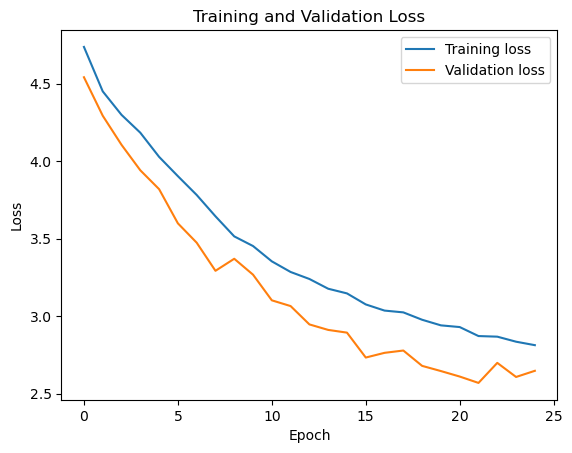

In [30]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### The five-layer model achieved higher accuracy on the training set. 
#### And it also performed better on the validation set and the test set.
#### The increased complexity of the five-layer model, the use of stronger data augmentation and larger image resizing (224-pixel) contributed to this improved performance.
#### Since it took me 91mins and 51.1s to train this one sepcific five-layer model, I will not redo the loop to find the best combination of L2 and dropout.


#### Based on the accuracy, it seems that using transfer learning could be beneficial. The five-layer still have relatively low accuracy, indicating that the models might be struggling with the current task.

#### Benefits of Using Transfer Learning:
#### Improved Accuracy: Using a pre-trained model for feature extraction or fine-tuning (such as ResNet, VGG, or Inception) can significantly improve the performance of the deep learning tasks, as the pre-trained model has already learned rich feature representations from large datasets.
#### Reduced Training Time: Pre-trained models have already done most of the heavy lifting, so I only need to fine-tune them on new data, which can greatly reduce training time.
#### Suitable for Small Datasets: The transfer learning can leverage the weights of the pre-trained model to achieve good performance even with smaller datasets